In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [10]:
df = pd.read_csv('../data/20250521_083725_processed_data.csv')

In [11]:
df.dtypes

customer_id                 int64
name                       object
email                      object
signup_date                object
plan                       object
monthly_spend             float64
last_login                 object
churned                     int64
churn_date                 object
event_id                    int64
event_time                 object
session_id                 object
page_url                   object
source_file                object
event_type_add_to_cart       bool
event_type_click_ad          bool
event_type_logout            bool
event_type_page_view         bool
event_type_purchase          bool
event_type_search            bool
dtype: object

In [12]:
def engineer_features(df):
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # 1. Handle datetime columns
    date_columns = ['signup_date', 'last_login', 'churn_date', 'event_time']
    for col in date_columns:
        if col in df.columns:
            # Convert to datetime with error handling
            df[col] = pd.to_datetime(df[col], errors='coerce')
            
            # Extract numeric features from dates
            if col != 'churn_date':  # Don't create features from churn_date as it's a future event
                df[f'{col}_year'] = df[col].dt.year
                df[f'{col}_month'] = df[col].dt.month
                df[f'{col}_day'] = df[col].dt.day
                df[f'{col}_dayofweek'] = df[col].dt.dayofweek
                
                if col == 'event_time':
                    df[f'{col}_hour'] = df[col].dt.hour
    
    # 2. Calculate time-based features
    if 'signup_date' in df.columns and 'last_login' in df.columns:
        df['account_age_days'] = (df['last_login'] - df['signup_date']).dt.days
        # Handle negative values or NaN
        df['account_age_days'] = df['account_age_days'].clip(lower=0)
        
    # 3. Convert boolean columns to int (0/1)
    event_cols = [col for col in df.columns if col.startswith('event_type_')]
    for col in event_cols:
        df[col] = df[col].astype(int)
    
    # 4. Calculate engagement metrics
    df['total_events'] = df[event_cols].sum(axis=1)
    
    # Weighted engagement score
    df['engagement_score'] = (
        df['event_type_purchase'] * 5 +
        df['event_type_add_to_cart'] * 3 +
        df['event_type_page_view'] * 1 +
        df['event_type_search'] * 2
    )
    
    # 5. Handle categorical variables
    df['plan'] = df['plan'].astype('category')
    
    # 6. Clean up monetary values
    df['monthly_spend'] = df['monthly_spend'].fillna(0)
    
    # 7. Drop original datetime columns and non-predictive columns
    columns_to_drop = [
        'name', 'email', 'signup_date', 'last_login', 'churn_date', 
        'event_time', 'session_id', 'page_url', 'source_file', 'event_id'
    ]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    return df

In [13]:
data = engineer_features(df)

In [14]:
data.dtypes

customer_id                  int64
plan                      category
monthly_spend              float64
churned                      int64
event_type_add_to_cart       int32
event_type_click_ad          int32
event_type_logout            int32
event_type_page_view         int32
event_type_purchase          int32
event_type_search            int32
signup_date_year             int32
signup_date_month            int32
signup_date_day              int32
signup_date_dayofweek        int32
last_login_year              int32
last_login_month             int32
last_login_day               int32
last_login_dayofweek         int32
event_time_year              int32
event_time_month             int32
event_time_day               int32
event_time_dayofweek         int32
event_time_hour              int32
account_age_days             int64
total_events                 int64
engagement_score             int32
dtype: object

In [15]:
data.head()

,customer_id,plan,monthly_spend,churned,event_type_add_to_cart,event_type_click_ad,event_type_logout,event_type_page_view,event_type_purchase,event_type_search,...,last_login_day,last_login_dayofweek,event_time_year,event_time_month,event_time_day,event_time_dayofweek,event_time_hour,account_age_days,total_events,engagement_score
0,1,free,161.48,0,0,0,0,0,1,0,...,18,6,2024,2,10,5,10,504,1,5
1,1,free,161.48,0,1,0,0,0,0,0,...,18,6,2024,1,14,6,0,504,1,3
2,1,free,161.48,0,0,0,0,0,1,0,...,18,6,2024,2,24,5,20,504,1,5
3,1,free,161.48,0,0,0,0,0,1,0,...,18,6,2024,3,29,4,18,504,1,5
4,1,free,161.48,0,0,0,0,1,0,0,...,18,6,2024,3,13,2,10,504,1,1


# Data Analysis
Let's analyze the processed data and its relationships with churn

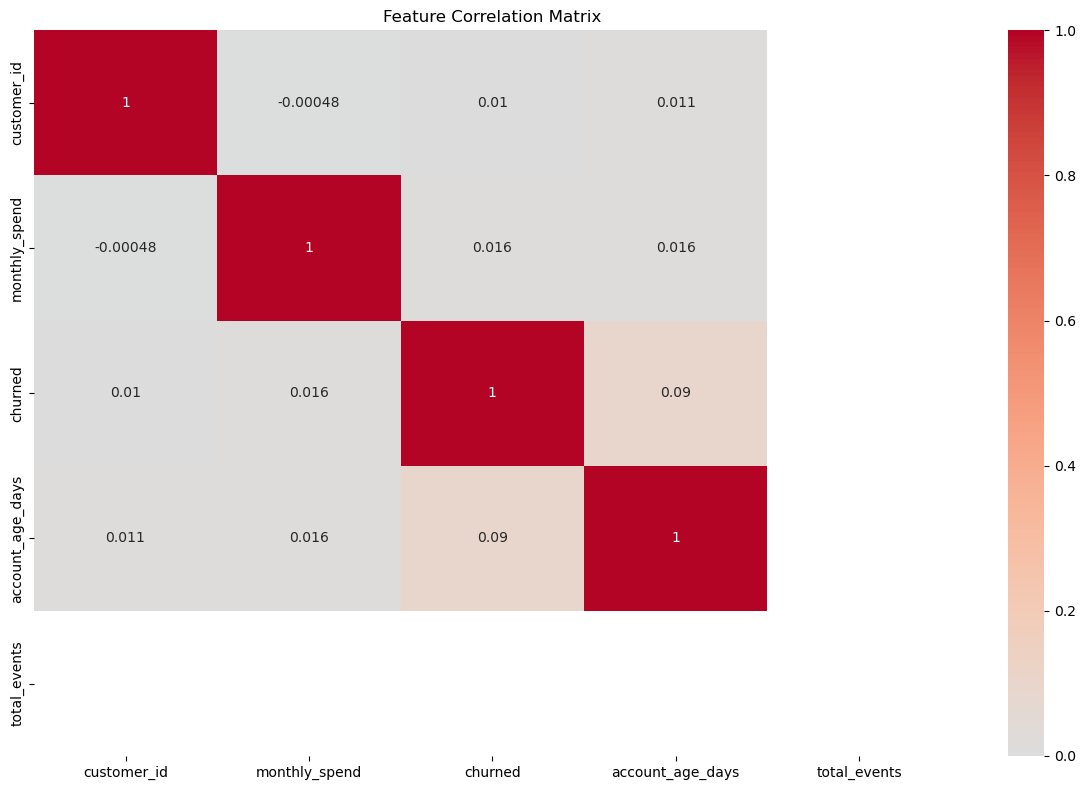

In [16]:
# Create correlation matrix for numeric columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = data[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

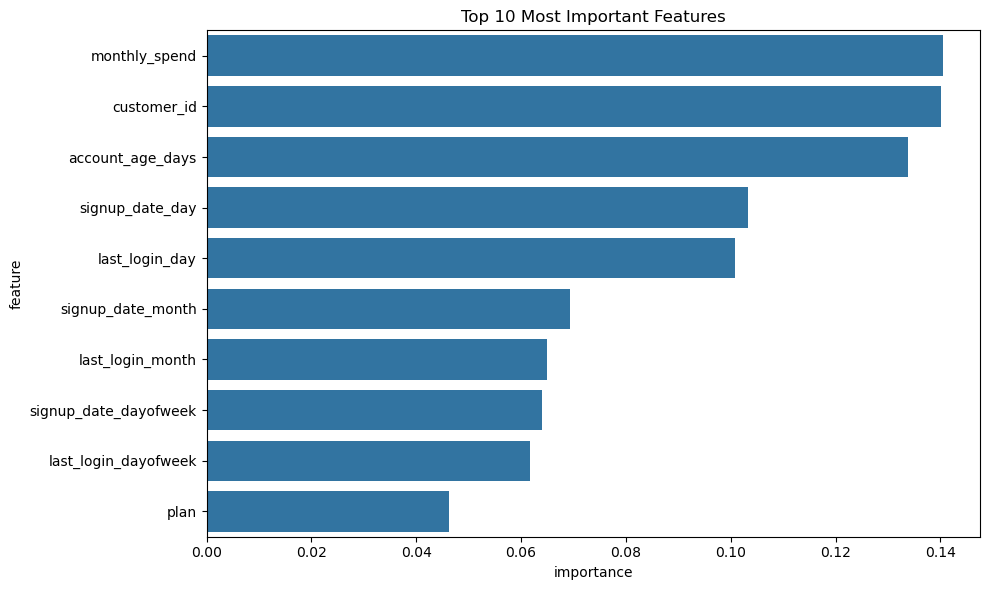

In [17]:
# Feature importance analysis
X = data.drop('churned', axis=1)
y = data['churned']

# Encode categorical variables
le = LabelEncoder()
for col in X.select_dtypes(include=['category']):
    X[col] = le.fit_transform(X[col])

# Train a simple random forest to get feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()